In [1]:
import datetime
import os
import time
from pathlib import Path
from typing import Dict, List, Optional, Union
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import utils as vutils
from dataset import EMnistDataset
import struct

gen_img_root = Path("dcGAN_eg/images")
weights_root = Path("dcGAN_eg/weights")
gen_img_root.mkdir(exist_ok=True)
weights_root.mkdir(exist_ok=True)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
path = '../EMNIST/emnist-byclass-train'
labels_path = path + '-labels-idx1-ubyte'
images_path = path + '-images-idx3-ubyte'
with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',lbpath.read(8))
    labels = np.fromfile(lbpath,dtype=np.uint8)
with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
    images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 28,28)
imgs = images
lbs = labels

In [3]:
# import idx2numpy
import copy
data = copy.deepcopy(imgs)
for i in range(data.shape[0]):
    data[i] = np.transpose(data[i])
    
with open('emnist_img.npy', 'wb') as f:
    np.save(f, data)
with open('emnist_label.npy', 'wb') as f:
    np.save(f, lbs)
print(data.shape)

(697932, 28, 28)


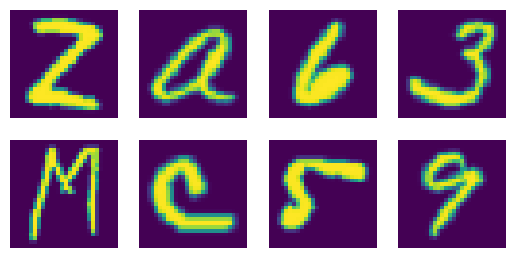

In [2]:
fig, axs = plt.subplots(3, 4)
images = np.load('emnist_img.npy')[:8]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [3]:
label = np.load('emnist_label.npy')
print(label.shape, label[0:8])

(697932,) [35 36  6  3 22 38  5  9]


In [1]:
datapath = {'img': 'emnist_img.npy',
            'label':"emnist_label.npy"}

In [4]:
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 100
        self.batch_size = 256
        self.lr = 1e-3
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 2000


opt = Parse()

In [5]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3080


In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2**4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size**2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [7]:
from torchvision.transforms import InterpolationMode
# Loss function
adversarial_loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
dataloader = DataLoader(
    EMnistDataset(datapath,
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(size=[32,32], interpolation=InterpolationMode.BICUBIC),
                                                transforms.Normalize([0.5], [0.5])]),
                    bonus = False),
    batch_size=opt.batch_size,
    shuffle=True,
)
# Optimizers
optimizer_G = torch.optim.RAdam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.RAdam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# record trianing loss
record: Dict[str, List[float]] = {"D_loss": [], "G_loss": []}

In [8]:
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(10, 10), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()


def to_td(second: Union[int, float]) -> str:
    # convert seconds to time delta
    return str(datetime.timedelta(seconds=int(second)))

 E001B001, [0:00:01/5 days, 16:26:05]  1.80s/epoch D_loss: 0.6932 = r0.6921 + f0.6942  G_loss: 0.6921

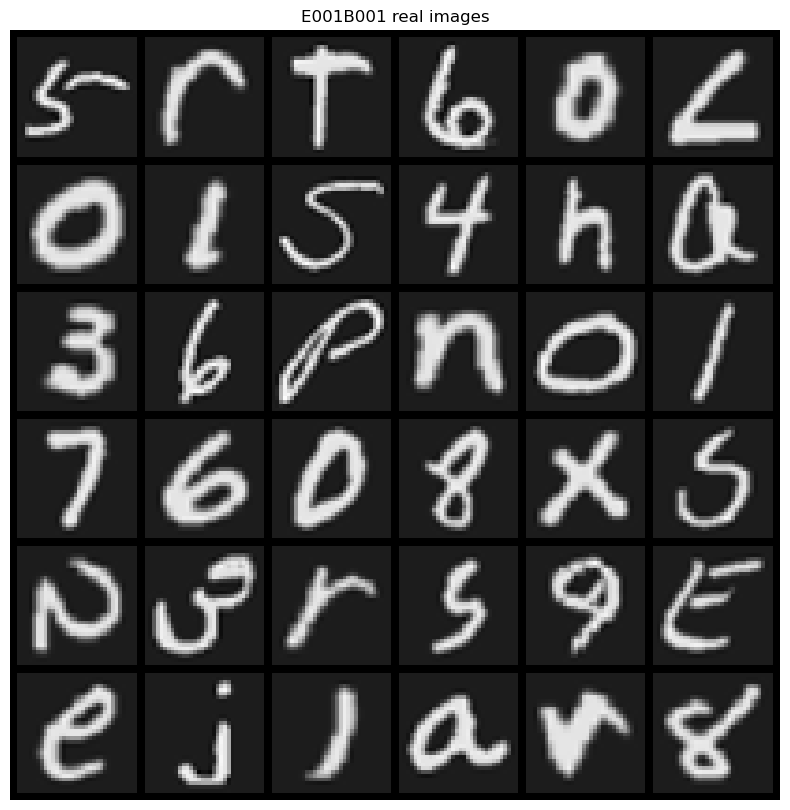

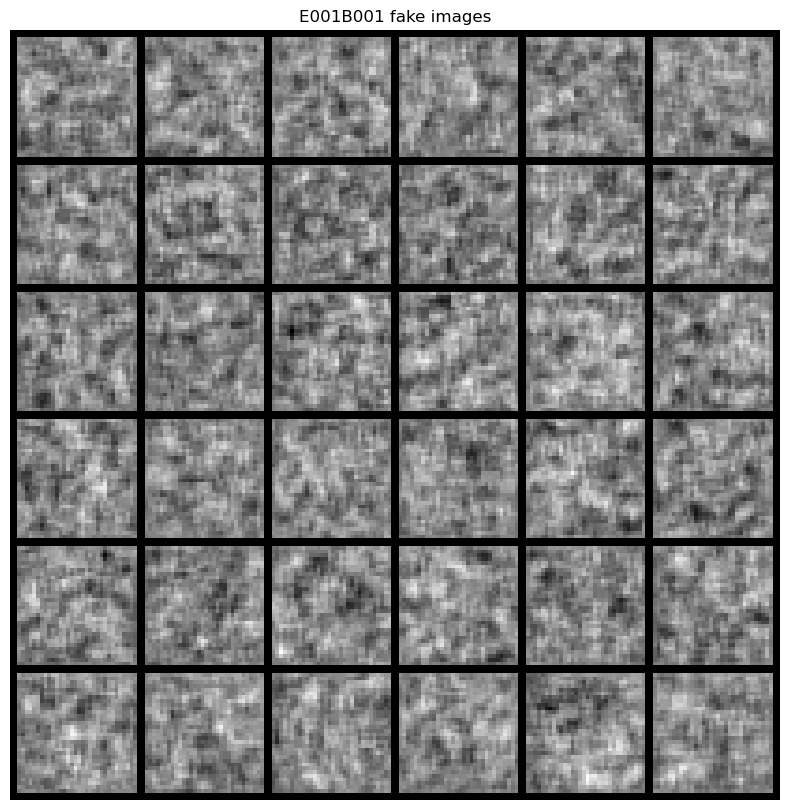

 E001B2710, [0:03:26/5:45:32] 103.36s/epoch D_loss: 0.5917 = r0.5874 + f0.5960  G_loss: 0.8567

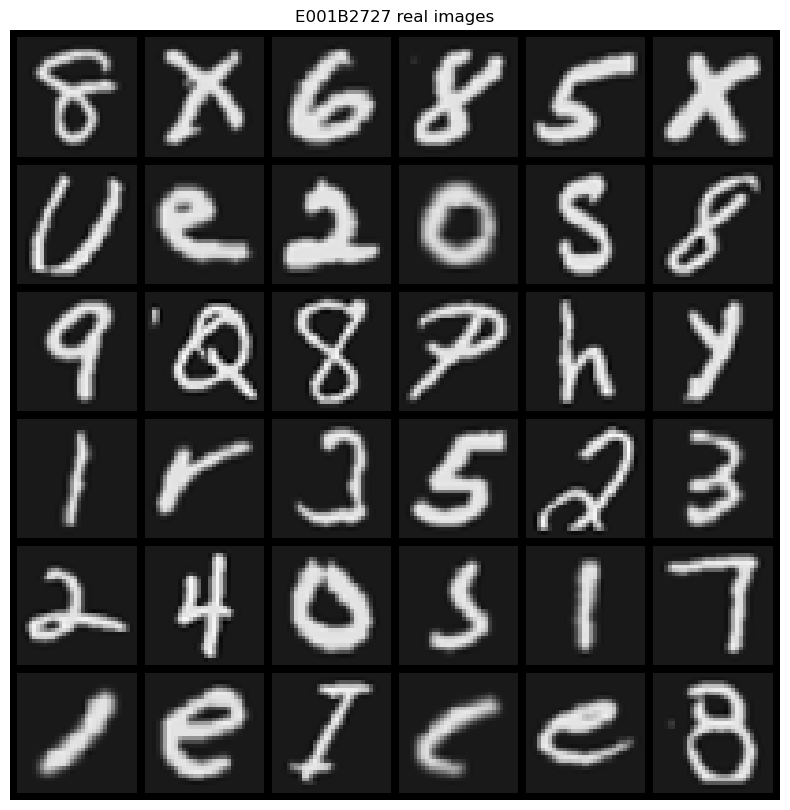

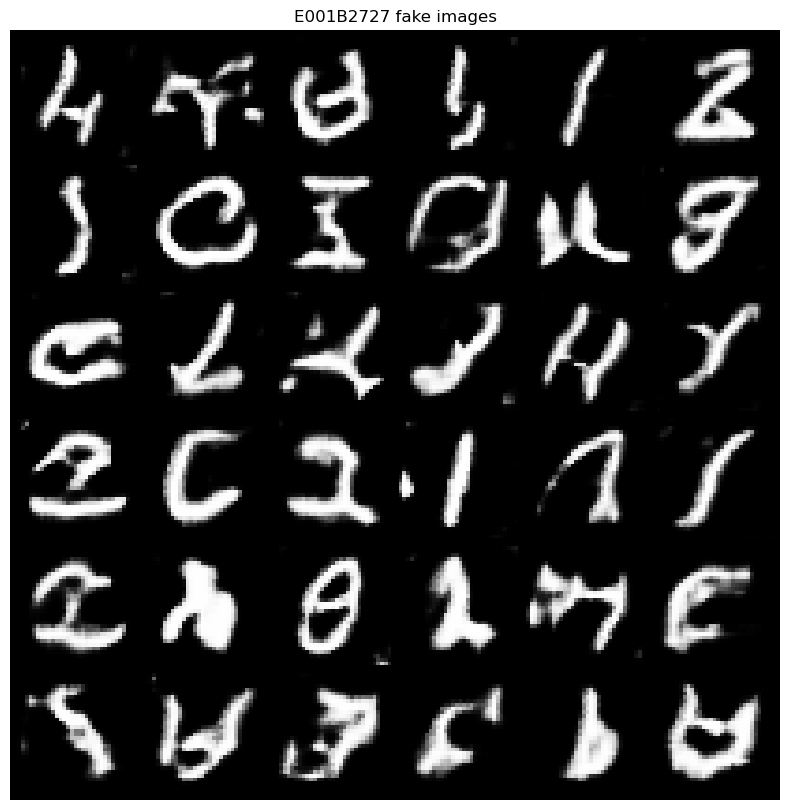

 E097B919, [5:28:57/5:41:28] 202.78s/epoch D_loss: 0.0010 = r0.0001 + f0.0019  G_loss: 8.90836712

In [ ]:
#  Training
result_path = './gan_DcGan_1'
training_start = time.time()
for epoch in range(opt.n_epochs):
    loss_d_e = 0
    loss_g_e = 0
    for i, (imgs,_) in enumerate(dataloader):

        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), opt.latent_dim).to(device)

        # Generate a batch of images
        fake_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        fake_pred = discriminator(fake_imgs)
        g_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_pred = discriminator(real_imgs)
        fake_pred = discriminator(fake_imgs.detach())
        real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred))
        fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        loss_d_e += d_loss.item()
        loss_g_e += g_loss.item()
        batches_done = epoch * len(dataloader) + i

        if batches_done % (opt.sample_interval // 100 + 1) == 0:
            diff = time.time() - training_start
            a_td = to_td(diff)
            al_td = to_td(diff * opt.n_epochs * len(dataloader) / (epoch * len(dataloader) + i + 1))
            per_df = diff / (epoch + 1 + i / len(dataloader))

            print(f"\r E{epoch+1:03}B{i+1:03}, [{a_td}/{al_td}] {per_df:5.2f}s/epoch",
                  f"D_loss: {d_loss.item():6.4f} = r{real_loss.item():6.4f} + f{fake_loss.item():6.4f}",
                  f" G_loss: {g_loss.item():6.4f}",
                  end="")

        if batches_done % opt.sample_interval == 0:
            # show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
            if batches_done > 10:
                torch.save(generator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G.pth")
                torch.save(discriminator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D.pth")
        if epoch == 0:
            if i == 0 or i == len(dataloader) - 1: 
                show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
        #  final model and result
        if (epoch == opt.n_epochs - 1) and (i == len(dataloader) - 1):
            if not os.path.isdir(result_path):
                os.mkdir(result_path)
            torch.save(generator.state_dict(), result_path + "/Generator weights.pth")
            torch.save(discriminator.state_dict(), result_path + "/Discriminator weights.pth")
            show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
    record["D_loss"].append(loss_d_e / len(dataloader))
    record["G_loss"].append(loss_g_e / len(dataloader))

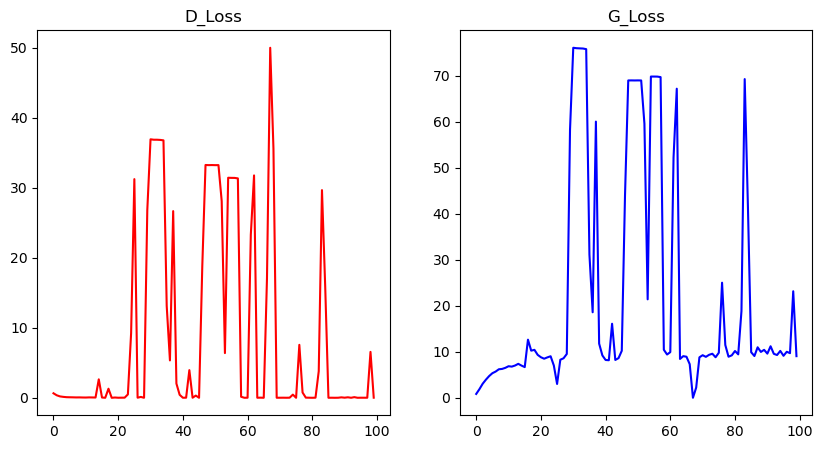

In [13]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(record["D_loss"], 'r')   # red line without marker
plt.title('D_Loss')
plt.subplot(122)
plt.plot( record["G_loss"], 'b') # blue solid line with filled circle marker
plt.title('G_Loss')
plt.savefig('DcGan_Loss.png')
plt.show()

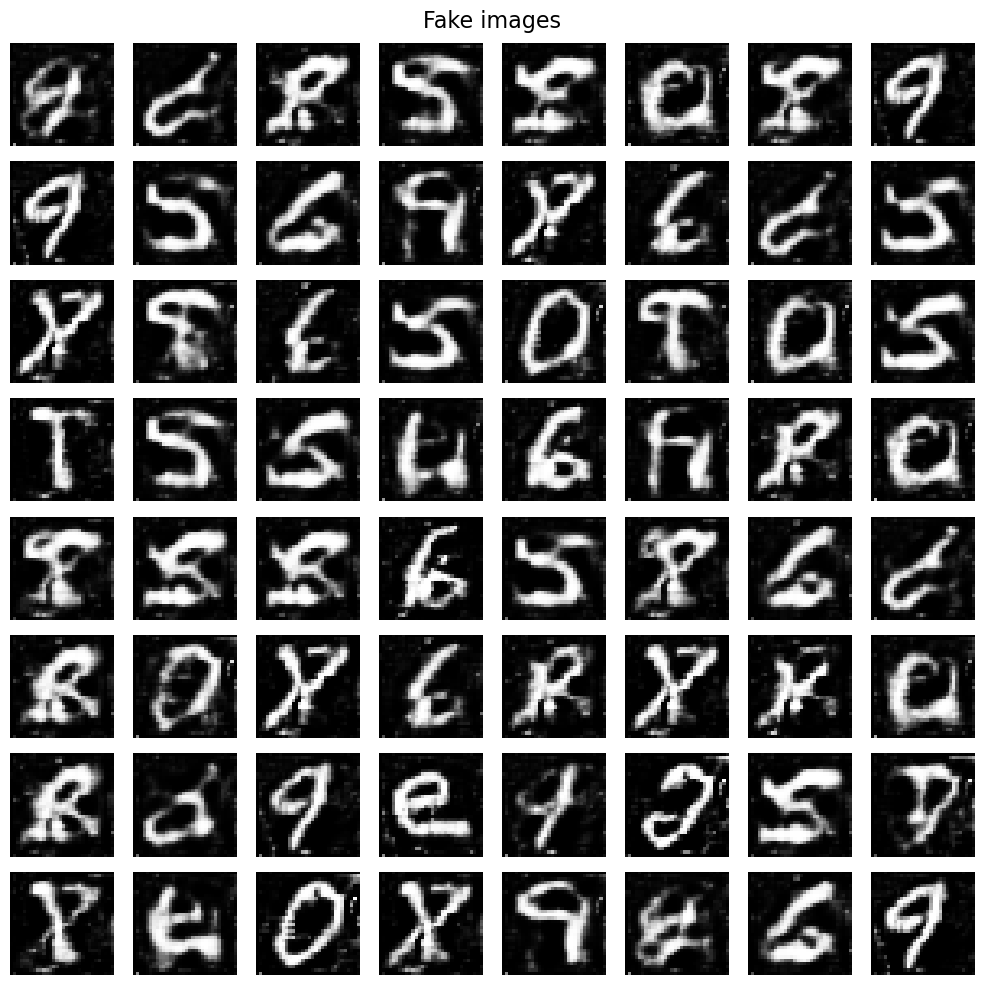

In [12]:
generator = Generator()

generator.load_state_dict(torch.load(result_path + "/Generator weights.pth"))
generator.eval()
z = torch.randn(opt.batch_size, opt.latent_dim)

fake_imgs = generator(z)
fake_imgs.shape

fake_imgs = fake_imgs.view(fake_imgs.size(0), opt.channels, opt.img_size, opt.img_size)

fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(fake_imgs):
        ax.imshow(fake_imgs[i].detach().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    else:
        ax.remove()
fig.suptitle('Fake images', fontsize=16)
fig.tight_layout()